# A simple optimization problem: NoTransport model


In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from dask.distributed import Client

In [2]:
from seapopym.configuration.acidity import (
    ForcingParameter,
)

from seapopym.configuration.acidity_bed import (
    AcidityBedConfiguration,
    FunctionalGroupParameter,
    FunctionalGroupUnit,
    FunctionalTypeParameter,
)

from seapopym.model import AcidityBedModel

from seapopym.standard.coordinate_authority import (
    create_latitude_coordinate,
    create_layer_coordinate,
    create_longitude_coordinate,
    create_time_coordinate,
)
from seapopym.standard.units import StandardUnitsLabels

from seapopym.configuration.no_transport import (
    ForcingUnit, KernelParameter
)

In [3]:
from seapopym_optimization.algorithm.genetic_algorithm.factory import GeneticAlgorithmFactory
from seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm import GeneticAlgorithmParameters
from seapopym_optimization.algorithm.genetic_algorithm.logbook import Logbook
from seapopym_optimization.configuration_generator.pteropods_bed_configuration_generator import (
    PteropodsBedConfigurationGenerator,
)
from seapopym_optimization.algorithm.genetic_algorithm.logbook import Logbook, LogbookCategory, LogbookIndex
from seapopym_optimization.cost_function import TimeSeriesScoreProcessor
from seapopym_optimization.cost_function.cost_function import CostFunction
from seapopym_optimization.cost_function.metric import rmse_comparator
from seapopym_optimization.functional_group import PteropodBedFunctionalGroup, Parameter
from seapopym_optimization.functional_group.base_functional_group import FunctionalGroupSet
from seapopym_optimization.functional_group.parameter_initialization import random_uniform_exclusive
from seapopym_optimization.observations.observation import DayCycle
from seapopym_optimization.observations.time_serie import TimeSeriesObservation


In [4]:
logging.basicConfig(level=logging.INFO, format="\n%(asctime)s - %(name)s - %(levelname)s - %(message)s")
logger = logging.getLogger("seapopym_optimization")
logger.setLevel(logging.INFO)

In [5]:
client = Client(memory_limit="10GB", n_workers=4)
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 128,Total memory: 37.25 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33791,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37257,Total threads: 32
Dashboard: http://127.0.0.1:45403/status,Memory: 9.31 GiB
Nanny: tcp://127.0.0.1:46469,


## 1. Import forcing data


In [6]:
data_path = "/home/salbernhe/workspace/pteropod/data/papa_forcings/"
aragonite_file = data_path + "daily_interp_aragonite_papa_1998_2020.nc"
temperature_file = data_path + "daily_temp_papa_1998_2020.nc"
npp_file = data_path + "daily_pp_papa_1998_2020.nc"
npp_behrenfeld_file = data_path + "daily_BEHRENFELD_papa_1998_2020.nc"

data_aragonite = xr.open_dataset(aragonite_file)
data_temperature = xr.open_dataset(temperature_file)
data_npp = xr.open_dataset(npp_file)

infos_forcings = [
    {
        "Variable": "Aragonite",
        "Shape": data_aragonite["omega_ar"].shape,
        "Unique values": len(np.unique(data_aragonite["omega_ar"])),
        "NaNs": int(np.isnan(data_aragonite["omega_ar"]).sum()),
    },
    {
        "Variable": "Temperature",
        "Shape": data_temperature["T"].shape,
        "Unique values": len(np.unique(data_temperature["T"])),
        "NaNs": int(np.isnan(data_temperature["T"]).sum()),
    },
    {
        "Variable": "NPP",
        "Shape": data_npp["npp"].shape,
        "Unique values": len(np.unique(data_npp["npp"])),
        "NaNs": int(np.isnan(data_npp["npp"]).sum()),
    },
]

# print(infos_forcings)


In [7]:
temperature = xr.DataArray(
    dims=["T", "Y", "X", "Z"],
    coords={
        "T": create_time_coordinate(pd.to_datetime(data_temperature["time"].values)),
        "Y": create_latitude_coordinate([0]),
        "X": create_longitude_coordinate([0]),
        "Z": create_layer_coordinate([0]),
    },
    attrs={"units": StandardUnitsLabels.temperature},
    data=data_temperature["T"].values[:, np.newaxis, np.newaxis, np.newaxis],
)

acidity = xr.DataArray(
    dims=["T", "Y", "X", "Z"],
    coords={
        "T": create_time_coordinate(pd.to_datetime(data_aragonite["time"].values)),
        "Y": create_latitude_coordinate([0]),
        "X": create_longitude_coordinate([0]),
        "Z": create_layer_coordinate([0]),
    },
    attrs={"units": StandardUnitsLabels.acidity},
    data=data_aragonite["omega_ar"].values[:, np.newaxis, np.newaxis, np.newaxis],
)

primary_production = xr.DataArray(
    dims=["T", "Y", "X"],
    coords={
        "T": create_time_coordinate(pd.to_datetime(data_npp["time"].values)),
        "Y": create_latitude_coordinate([0]),
        "X": create_longitude_coordinate([0]),
    },
    attrs={"units": "mg/m2/day"},
    data=data_npp["npp"].values[:, np.newaxis, np.newaxis],
)


dataset = xr.Dataset({"temperature": temperature, "primary_production": primary_production, "acidity": acidity})


In [8]:
dataset = dataset.dropna("T")     #drop les nan à chaque T (en l'occurence acidité)
dataset = dataset.resample(T="1D").mean().interpolate_na(dim="T")

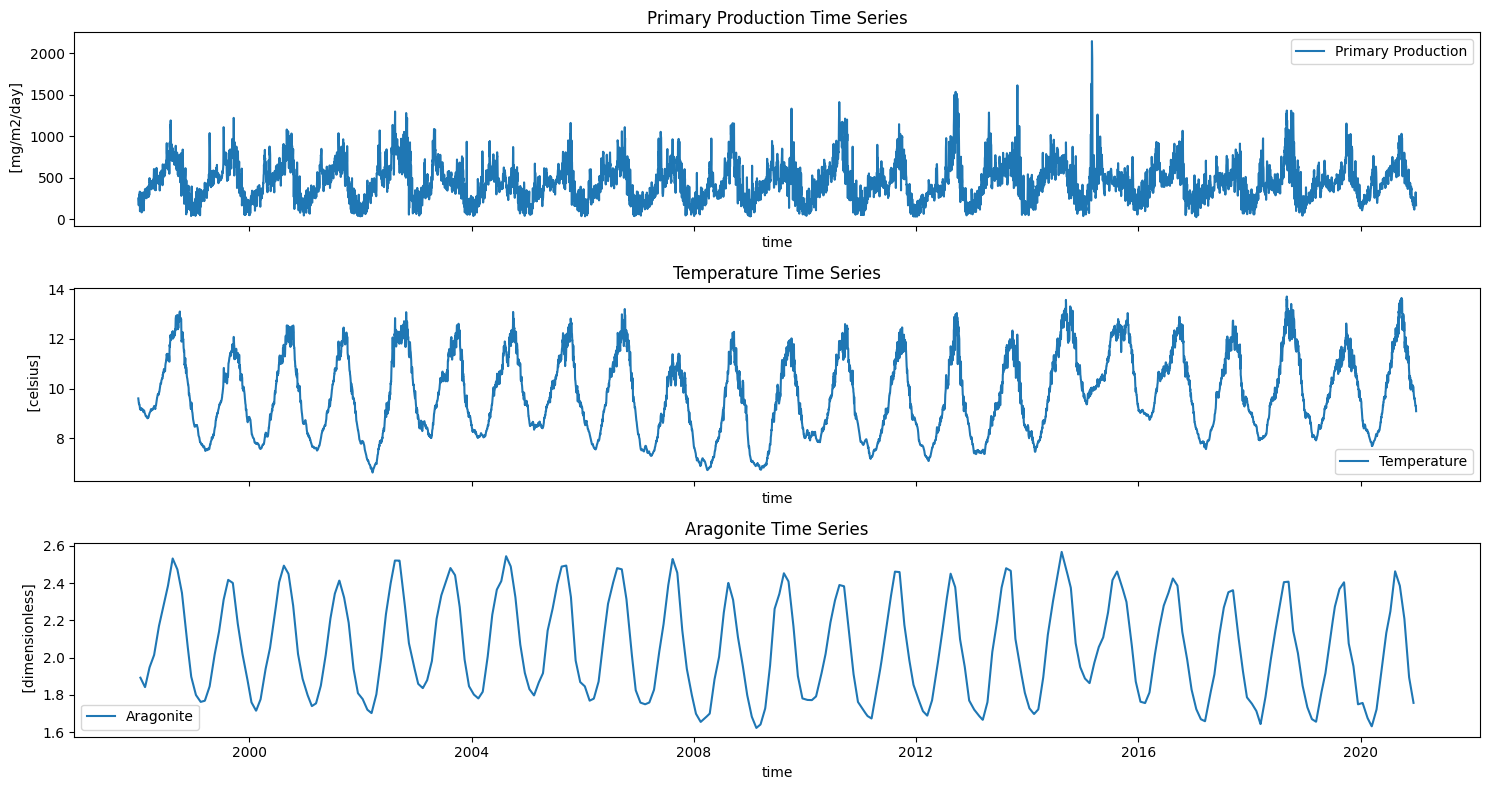

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8), sharex=True)
primary_production.plot(label="Primary Production", ax=ax1)
ax1.legend()
ax1.set_title("Primary Production Time Series")
temperature.plot(label="Temperature", ax=ax2)
ax2.legend()
ax2.set_title("Temperature Time Series")
acidity.plot(label="Aragonite", ax=ax3)
ax3.legend()
ax3.set_title("Aragonite Time Series")
fig.tight_layout()
plt.show()

In [10]:
forcing_parameter = ForcingParameter(
    temperature=ForcingUnit(forcing=dataset.temperature),
    primary_production=ForcingUnit(forcing=dataset.primary_production),
    acidity=ForcingUnit(forcing=dataset.acidity),
)


2025-10-06 15:20:00,239 - seapopym.configuration.no_transport.forcing_parameter - WARNING - primary_production unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.

2025-10-06 15:20:00,255 - seapopym.configuration.no_transport.forcing_parameter - WARNING - primary_production unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.


## 2. Format observations


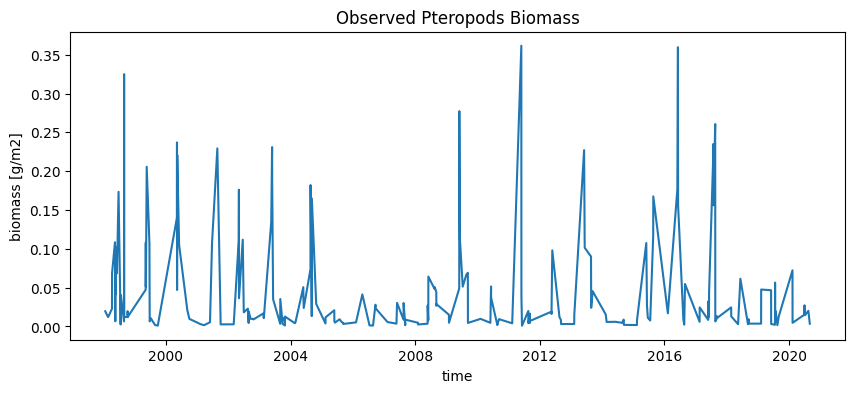

In [11]:
pteropod_file = "/home/salbernhe/workspace/pteropod/data/pteropod_data/time_serie_pter_papa_1998_2020_clean_k_075.nc"

data_pteropod = xr.open_dataset(pteropod_file)

observed_biomass = data_pteropod["pteropod_biomass_gm2"]

# Étendre les dimensions pour correspondre au format cible
observed_biomass = observed_biomass.expand_dims({"Z": [0], "Y": [0], "X": [0]})

# Renommer la dimension temporelle en "T"
observed_biomass = observed_biomass.rename({"time": "T"})

observed_biomass.name = "biomass"
observed_biomass.attrs = {"units":"g/m2"}
observed_biomass

#observed_biomass = observed_biomass.sel(T=slice("2000", "2019"))

plt.figure(figsize=(10, 4))
observed_biomass.plot()
plt.title("Observed Pteropods Biomass")

# Create observation object
observation = TimeSeriesObservation(
    name="Pteropods Biomass", observation=observed_biomass, observation_type=DayCycle.DAY
)

## 3. Define functional groups for optimization


In [12]:
epsilon = np.finfo(float).eps
functional_groups = [
    PteropodBedFunctionalGroup(
        name="Pteropods",
        day_layer=0,
        night_layer=0,
        energy_transfert=Parameter("D1N1_energy_transfert", epsilon, 0.5, init_method=random_uniform_exclusive),
        lambda_0=-19.4,  # Bed et al.
        gamma_lambda_temperature=11.5,  # Bed et al.
        gamma_lambda_acidity=-32.7,  # Bed et al.
        survival_rate_0=13.49,  # Bed et al.
        gamma_survival_rate_temperature=-2.475,  # Bed et al.
        gamma_survival_rate_acidity=10.10,  # Bed et al.
        tr_0=Parameter("D1N1_tr_0", epsilon, 100, init_method=random_uniform_exclusive),
        gamma_tr=Parameter("D1N1_gamma_tr", -0.5, -epsilon, init_method=random_uniform_exclusive),
    ),
]

fg_set = FunctionalGroupSet(functional_groups=functional_groups)

## 4. Create cost function with processor


In [13]:
# Create processor with RMSE metric
processor = TimeSeriesScoreProcessor(comparator=rmse_comparator)

# Create cost function
cost_function = CostFunction(
    configuration_generator=PteropodsBedConfigurationGenerator(AcidityBedModel),
    functional_groups=fg_set,
    forcing=forcing_parameter,
    kernel=KernelParameter(),
    observations=[observation],
    processor=processor,
)

## 5. Initialize logbook with Sobol samples


In [14]:
logbook = Logbook.from_sobol_samples(fg_set, sample_number=2, fitness_names=["Pteropods Biomass"])

## 6. Configure and run genetic algorithm


In [15]:
metaparam = GeneticAlgorithmParameters(
    ETA=20,
    INDPB=0.33,
    CXPB=0.9,
    MUTPB=1,
    NGEN=10,
    POP_SIZE=10,
    cost_function_weight=(-1,),  # Minimize RMSE
)

In [16]:
genetic_algorithm = GeneticAlgorithmFactory.create_distributed(
    meta_parameter=metaparam,
    cost_function=cost_function,
    client=client,
    logbook=logbook,
)
genetic_algorithm


2025-10-06 15:20:31,139 - seapopym_optimization.algorithm.genetic_algorithm.factory - INFO - Creating genetic algorithm in distributed mode

2025-10-06 15:20:31,140 - seapopym_optimization.algorithm.genetic_algorithm.factory - INFO - Distributing forcing to Dask workers with broadcast=True...

2025-10-06 15:20:34,223 - seapopym_optimization.algorithm.genetic_algorithm.factory - INFO - Distributing observation 'Pteropods Biomass' to Dask workers with broadcast=True...


GeneticAlgorithm(meta_parameter=GeneticAlgorithmParameters(ETA=20, INDPB=0.33, CXPB=0.9, MUTPB=1, NGEN=10, POP_SIZE=10, TOURNSIZE=3, cost_function_weight=(np.float64(-1.0),)), cost_function=CostFunction(configuration_generator=PteropodsBedConfigurationGenerator(model_class=<class 'seapopym.model.acidity_model.AcidityBedModel'>), functional_groups=FunctionalGroupSet(functional_groups=[PteropodBedFunctionalGroup(name='Pteropods', day_layer=0, night_layer=0, energy_transfert=Parameter(name='D1N1_energy_transfert', lower_bound=np.float64(2.220446049250313e-16), upper_bound=0.5, init_method=<function random_uniform_exclusive at 0x7f65316ffa60>), lambda_0=-19.4, gamma_lambda_temperature=11.5, gamma_lambda_acidity=-32.7, survival_rate_0=13.49, gamma_survival_rate_temperature=-2.475, gamma_survival_rate_acidity=10.1, tr_0=Parameter(name='D1N1_tr_0', lower_bound=np.float64(2.220446049250313e-16), upper_bound=100, init_method=<function random_uniform_exclusive at 0x7f65316ffa60>), gamma_tr=Param

# 7. Run optimization


In [17]:
optimization_results = genetic_algorithm.optimize()


2025-10-06 15:20:38,140 - seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm - INFO - Logbook found. Loading last generation.

2025-10-06 15:20:38,144 - seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm - WARNING - Some individuals in the logbook have no fitness values. Re-evaluating the population.

2025-10-06 15:20:59,423 - seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm - INFO - Generation 1 / 10.

2025-10-06 15:21:07,499 - seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm - INFO - Generation 2 / 10.

2025-10-06 15:21:15,778 - seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm - INFO - Generation 3 / 10.

2025-10-06 15:21:24,302 - seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm - INFO - Generation 4 / 10.

2025-10-06 15:21:32,199 - seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm - INFO - Generation 5 / 10.

2025-10-06 15:21:40,504 - seapopym_optimization

## 8. Plot results


Extract the best individual from the logbook


In [18]:
optimization_results


category                                                      Parametre  \
name                                              D1N1_energy_transfert   
Generation Is_From_Previous_Generation Individual                         
0          False                       0                       0.250812   
                                       1                       0.335510   
                                       2                       0.250812   
                                       3                       0.250812   
                                       4                       0.335510   
...                                                                 ...   
9          False                       5                       0.004413   
                                       6                       0.003877   
                                       7                       0.004413   
                                       8                       0.004413   
                                       9                       0.004413   

category                                                                    \
name                                               D1N1_tr_0 D1N1_gamma_tr   
Generation Is_From_Previous_Generation Individual                            
0          False                       0           29.579119     -0.023534   
                                       1           29.579119     -0.023534   
                                       2            0.034235     -0.023534   
                                       3           29.579119     -0.172784   
                                       4            0.034235     -0.172784   
...                                                      ...           ...   
9          False                       5           92.876647     -0.264310   
                                       6           99.715492     -0.173914   
                                       7           99.715492     -0.221164   
                                       8           99.715492     -0.206379   
                                       9           99.913886     -0.221164   

category                                                    Fitness  \
name                                              Pteropods Biomass   
Generation Is_From_Previous_Generation Individual                     
0          False                       0                   0.004085   
                                       1                   0.005481   
                                       2                   0.004480   
                                       3                   0.004422   
                                       4                   0.006010   
...                                                             ...   
9          False                       5                   0.000072   
                                       6                   0.000067   
                                       7                   0.000071   
                                       8                   0.000071   
                                       9                   0.000071   

category                                          Weighted_fitness  
name                                              Weighted_fitness  
Generation Is_From_Previous_Generation Individual                   
0          False                       0                 -0.004085  
                                       1                 -0.005481  
                                       2                 -0.004480  
                                       3                 -0.004422  
                                       4                 -0.006010  
...                                                            ...  
9          False                       5                 -0.000072  
                                       6                 -0.000067  
                                       7                 -0.000071  
                                 

In [19]:
# Find the best individual (minimum weighted fitness)
best_idx = optimization_results[(LogbookCategory.WEIGHTED_FITNESS, LogbookCategory.WEIGHTED_FITNESS)].idxmax()
best_individual = optimization_results.loc[best_idx]

# Extract parameter values
best_params = best_individual[LogbookCategory.PARAMETER]
print("Best individual parameters:")
print(best_params)
print(
    f"\nBest fitness (RMSE): {best_individual[(LogbookCategory.WEIGHTED_FITNESS, LogbookCategory.WEIGHTED_FITNESS)]:.6f}"
)


Best individual parameters:
name
D1N1_energy_transfert     0.003877
D1N1_tr_0                99.715492
D1N1_gamma_tr            -0.173914
Name: (9, False, 6), dtype: float64

Best fitness (RMSE): -0.000067


In [20]:
# Create functional group with optimized parameters
optimized_fg = PteropodBedFunctionalGroup(
    name="Pteropods",
    day_layer=0,
    night_layer=0,
    energy_transfert=best_params["D1N1_energy_transfert"],
    lambda_0=-19.4,  # Bed et al.
    gamma_lambda_temperature=11.5,  # Bed et al.
    gamma_lambda_acidity=-32.7,  # Bed et al.
    survival_rate_0=13.49,  # Bed et al.
    gamma_survival_rate_temperature=-2.475,  # Bed et al.
    gamma_survival_rate_acidity=10.10,  # Bed et al.
    gamma_tr=best_params["D1N1_gamma_tr"],
    tr_0=best_params["D1N1_tr_0"],
)

# Generate configuration with optimized parameters
optimized_config = PteropodsBedConfigurationGenerator(AcidityBedModel).generate(
    functional_group_parameters=[optimized_fg],
    forcing_parameters=forcing_parameter,
    kernel=KernelParameter(),
)

# Run model with optimized parameters
with AcidityBedModel.from_configuration(optimized_config) as optimized_model:
    optimized_model.run()
    optimized_biomass = optimized_model.state.biomass

optimized_biomass = (
    optimized_biomass.expand_dims({"layer": [0]}).isel(functional_group=0).drop_vars(["functional_group"])
)
optimized_biomass = optimized_biomass.pint.quantify().pint.to("gram/m2")

optimized_biomass

Magnitude,[[[[0.0]] [[0.0]] [[0.0]] ... [[0.02899520719660406]] [[0.028426227980289608]] [[0.028256934529898175]]]]
Units,gram/meter2
Magnitude,[0]
Units,degrees_north
Magnitude,[0]
Units,degrees_east


/home/salbernhe/miniforge3/envs/seapopym_optimization_env/lib/python3.12/site-packages/xarray/core/variable.py:336: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


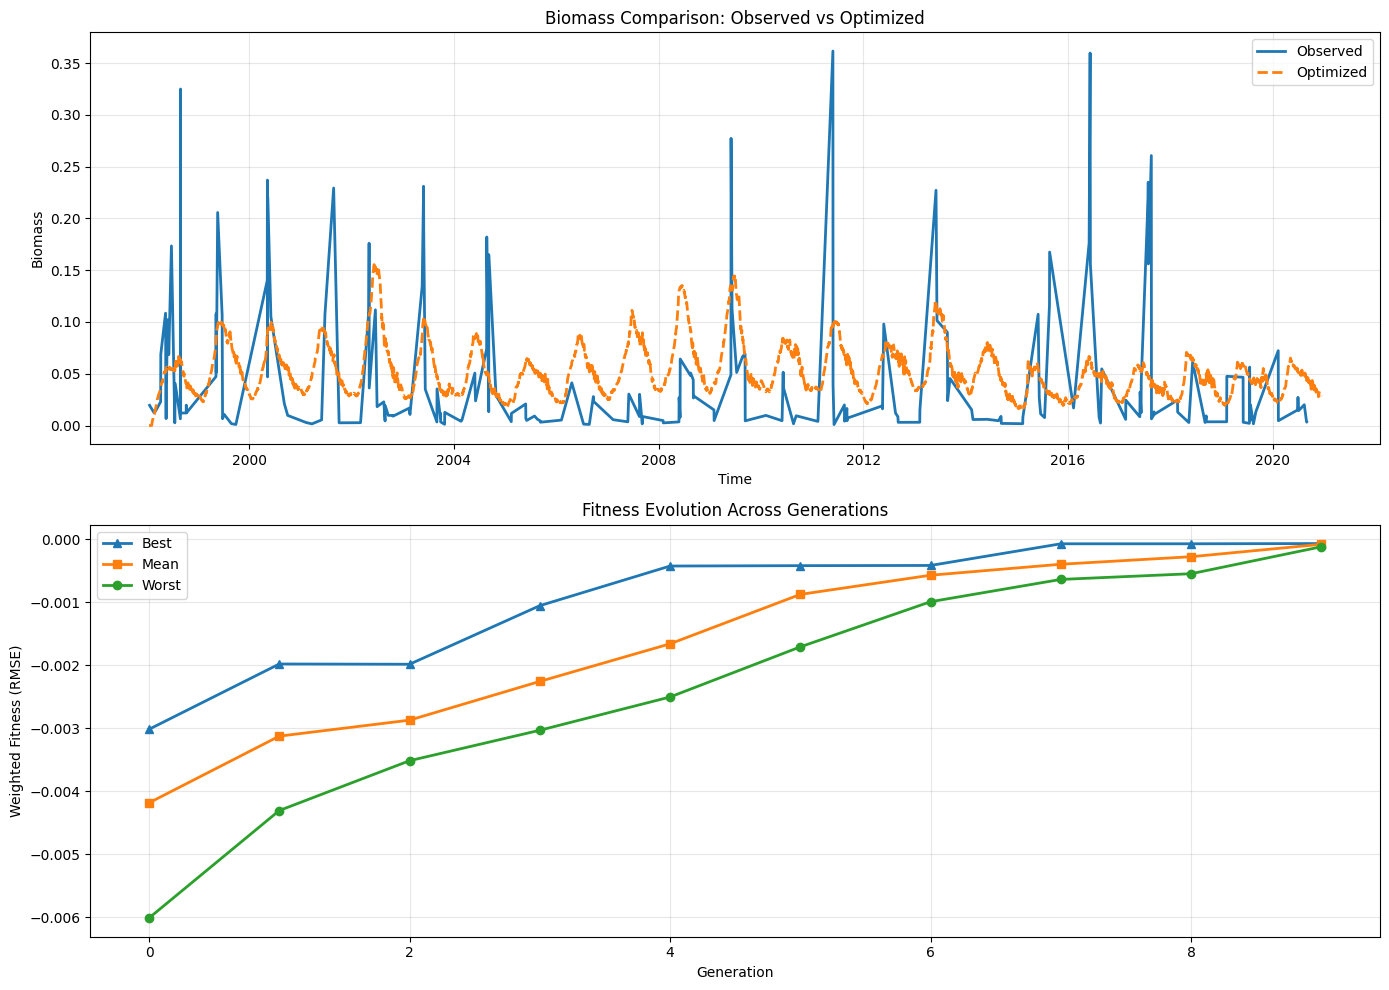


Final RMSE: -0.000067


In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot biomass comparison
observed_biomass.plot(ax=ax1, label="Observed", linewidth=2)
optimized_biomass.plot(ax=ax1, label="Optimized", linestyle="--", linewidth=2)
ax1.set_title("Biomass Comparison: Observed vs Optimized")
ax1.set_xlabel("Time")
ax1.set_ylabel("Biomass")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot fitness evolution
fitness_evolution = (
    optimization_results[LogbookCategory.WEIGHTED_FITNESS].groupby(LogbookIndex.GENERATION).agg(["min", "mean", "max"])
)

fitness_evolution["Weighted_fitness"]["max"].plot(ax=ax2, label="Best", marker="^", linewidth=2)
fitness_evolution["Weighted_fitness"]["mean"].plot(ax=ax2, label="Mean", marker="s", linewidth=2)
fitness_evolution["Weighted_fitness"]["min"].plot(ax=ax2, label="Worst", marker="o", linewidth=2)
ax2.set_title("Fitness Evolution Across Generations")
ax2.set_xlabel("Generation")
ax2.set_ylabel("Weighted Fitness (RMSE)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal RMSE: {best_individual[(LogbookCategory.WEIGHTED_FITNESS, LogbookCategory.WEIGHTED_FITNESS)]:.6f}")


In [22]:
optimized_biomass = optimized_biomass.pint.dequantify()
optimized_biomass.to_netcdf("/home/salbernhe/workspace/pteropod/simulations_outputs/opti_biomass_papa.nc")
